# Accelerated MWTA

## Intro
* **Date**: 1/1/2021
* **What**: First experiment of 2021, that's what!  As stated in the README, the current goal for the year is too build something so reality-altering that it doesn't make most sense for me to go back to school come August.  God.  Fuck college.  Anyway, in this experiment, I'm just doing simple MWTA, but I'm seeing what kind of acceleration I can get with Numba compilation. 
* **Why**: Cause I want my algos to run faster.  That's pretty obvious.
* **Hopes**: Y'all, I'd be quite happy if I could get that sweet, sweet 100x speedup that's been advertised.  I'd be *very* happy if I could get 1000x speedup, but I think that's probably wistful thinking.
* **Limitations**: I haven't used Numba before, so I might have to kick it a lil bit to get it working.  Also, things always like to break, so I'll have to convince it not to.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from numba import njit
from time import time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()
    
def relu(x):
    return (abs(x) + x) / 2

In [2]:
def mwta_no_jit(Nep, T_s, Kx, Ky, m_len, tr_len, prec, n_w, fig):
    N = Kx * Ky
    
    # Feedforward
    w = np.random.uniform(0, 1, (N, m_len))
    xi = 0.002
    
    for ep in range(Nep):
        inputs = m_flat_tr[np.random.permutation(tr_len)]
        start = time()
        for i in range(T_s):
            v = inputs[i].reshape(-1, 1)
            p = w @ v
            winners = np.argsort(p, axis=0)[-n_w:]
            mask = np.zeros((N, 1))
            mask[winners] = 1
            o = mask * p
            r = w.T @ o
            mod_r = np.maximum(r, prec)
            e = v - r

            w += w * o * (e / mod_r).T * xi
        print("Epoch ", ep, " time: ", int(100 * (time() - start)) / 100, " sec")
        
        draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


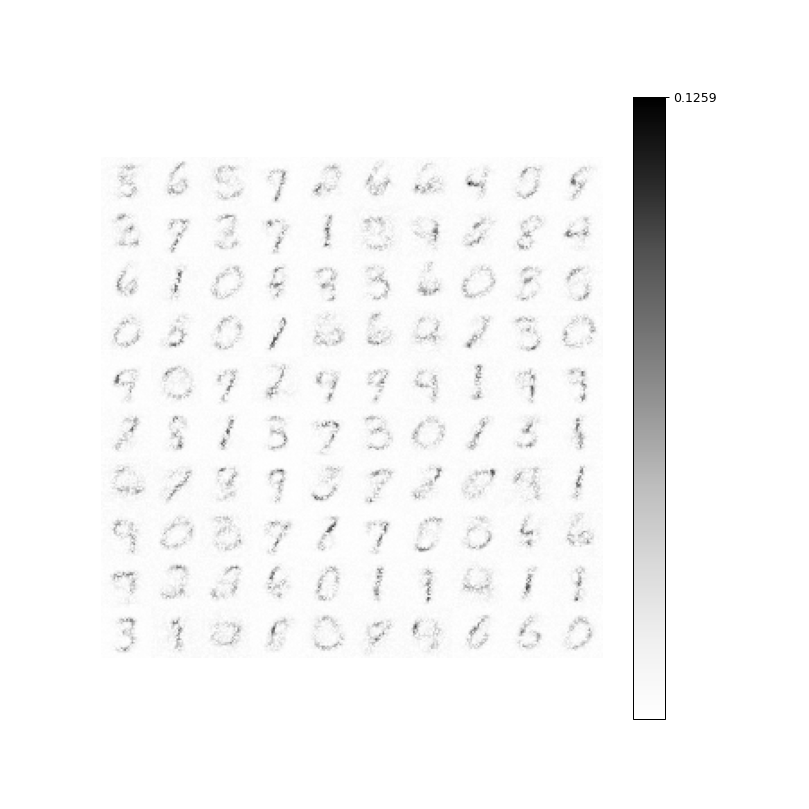

Epoch  0  time:  2.74  sec


In [28]:
fig = plt.figure(figsize=(10, 10))

Nep = 1
T_s = 6000

Kx = 10
Ky = 10
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

mwta_no_jit(Nep, T_s, Kx, Ky, m_len, tr_len, prec, n_w, fig)

In [7]:
@njit(fastmath=True)
def mwta_jit(Nep, T_s, Kx, Ky, m_len, tr_len, prec, n_w):
    N = Kx * Ky
    
    # Feedforward
    w = np.random.uniform(0, 1, (N, m_len))
    xi = 0.002
    
    for ep in range(Nep):
        inputs = m_flat_tr[np.random.permutation(tr_len)]
        for i in range(T_s):
            v = inputs[i].reshape(-1, 1)
            p = w @ v
            winners = np.argsort(p.reshape(-1))[-n_w:]
            mask = np.zeros((N, 1))
            mask[winners] = 1
            o = mask * p
            r = w.T @ o
            mod_r = np.maximum(r, prec)
            e = v - r

            w += w * o * (e / mod_r).T * xi
        
    return w

Time : 31.94  sec


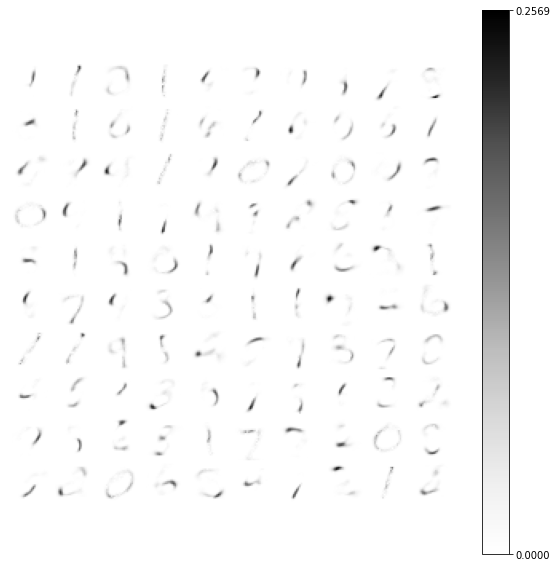

In [12]:
Nep = 10
T_s = 6000

Kx = 10
Ky = 10
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

start = time()
w = mwta_jit(Nep, T_s, Kx, Ky, m_len, tr_len, prec, n_w)
print("Time :", int(100 * (time() - start)) / 100, " sec")
fig = plt.figure(figsize=(10, 10))
draw_weights(w, Kx, Ky, 28, fig)

## Analysis Dialog

Hmm.  Numba appeared to make it go slower.  Great.  Why is that happening?  

Ok, I did some research, and it looks like Numba actually isn't really all that great.  What about that one video I watched advertising 1000x speedup?  That idiot was using pure python as his base code.  No wonder he got such a speedup.

In digging around a bit, it looked like people are able to get maybe a 2x speedup using Numba.  LAME!  I want frikin 100x speedup!

However, before I close up this experiment, there's one more thing I want to try.  CuPy is a library that essentially tries to do Numpy with CUDA, so we get some GPU boosting.  Apparently it might be able to get ~10x speedup on Numpy code.  I gotta learn it, and then I'll implement this junk using it.

In [2]:
import cupy as cp

In [11]:
### Numpy and CPU
s = time()
x_cpu = np.ones((1000,1000,200))
e = time()
print(e - s)
### CuPy and GPU
s = time()
x_gpu = cp.ones((1000,1000,200))
cp.cuda.Stream.null.synchronize()
e = time()
print(e - s)

0.9324741363525391
0.18450713157653809


In [12]:
### Numpy and CPU
s = time()
x_cpu *= 5
e = time()
print(e - s)
### CuPy and GPU
s = time()
x_gpu *= 5
cp.cuda.Stream.null.synchronize()
e = time()
print(e - s)

0.14063334465026855
0.032912254333496094


Hmm.  It looks like it might only help when my arrays are humongous.

But, still, let's see how fast this bad boi works.

<IPython.core.display.Javascript object>


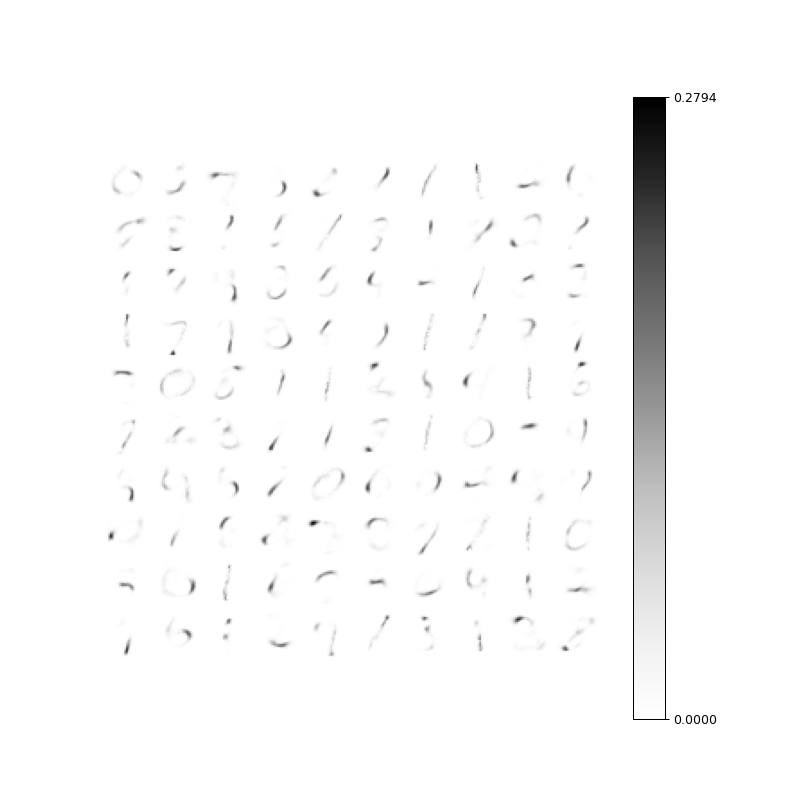

100%|███████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1761.14it/s]


In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.002

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
#     start = time()
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
#     print("Epoch ", ep, " time: ", int(100 * (time() - start)) / 100, " sec")

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

Wow.  I mean it's bad, but not as bad as I thought.  I'm going to throw this on 400 neurons and see how it does.

And I can use tqdm!  Yay!

<IPython.core.display.Javascript object>


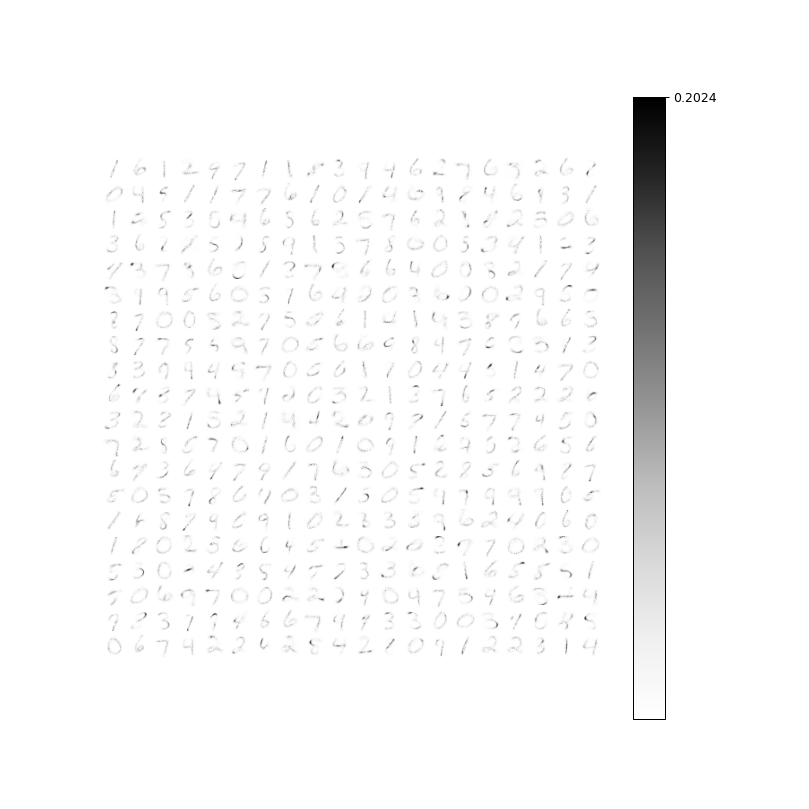

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:10<00:00, 599.50it/s]


In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 20
Ky = 20
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.002

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

Holy snoots.  I think that might have gone 6x faster on GPU than cpu.  Well that's deeply dope.  ...and *hehe* you know what I gotta try now.  That's right!  900 neurons!  Let's see how this bad boi does!

<IPython.core.display.Javascript object>


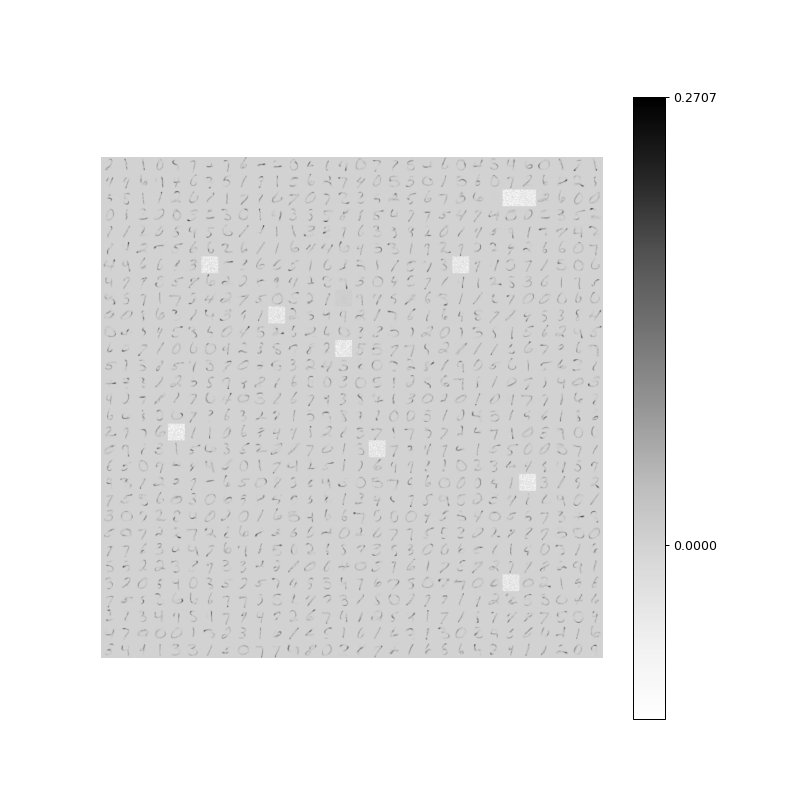

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 808.39it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 30
Ky = 30
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.01

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

Holy holy holy snoot.  That ran so incredibly fast!  Oh my gosh!  I think I might be getting linear time complexity with GPU!  That's *deeply deeply* dope!  I'm going to run that again with some clipping, hopefully that helps those splotches.

<IPython.core.display.Javascript object>


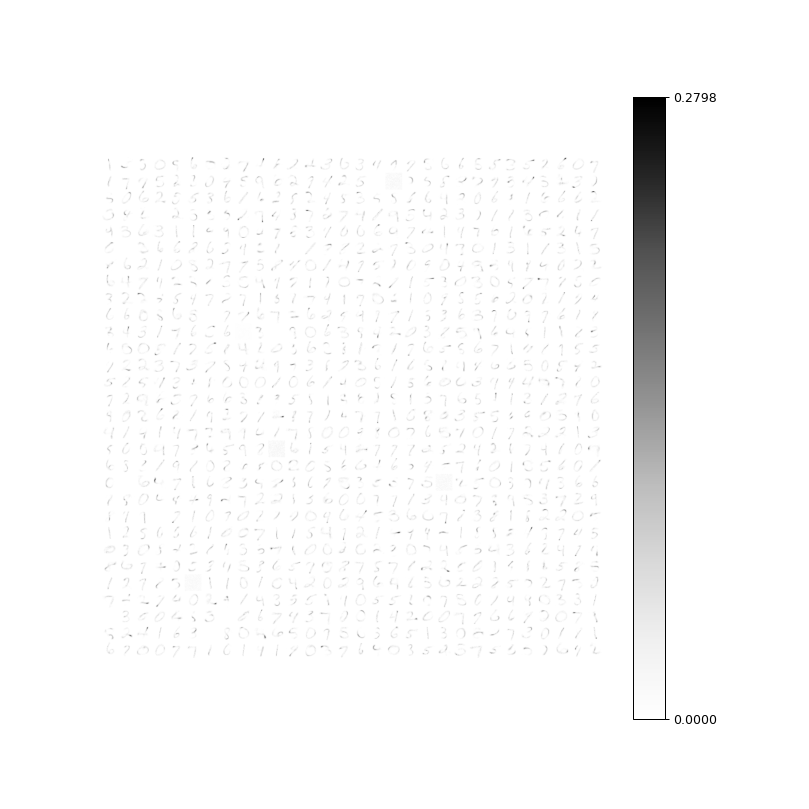

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:24<00:00, 249.36it/s]


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 30
Ky = 30
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.01

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

In [6]:
def reconstruct(img_i, w, Kx, Ky):
    s_len = 28

    img = gp_flat[img_i]

    v = img.reshape(-1, 1)
    p = w @ v
    winners = cp.argsort(p, axis=0)[-n_w:]
    mask = cp.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(s_len, s_len).get(), cmap="Greys", vmax=1)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o.reshape(Ky, Kx).get(), cmap="Greys")

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(r.reshape(s_len, s_len).get(), cmap="Greys", vmax=1)

    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


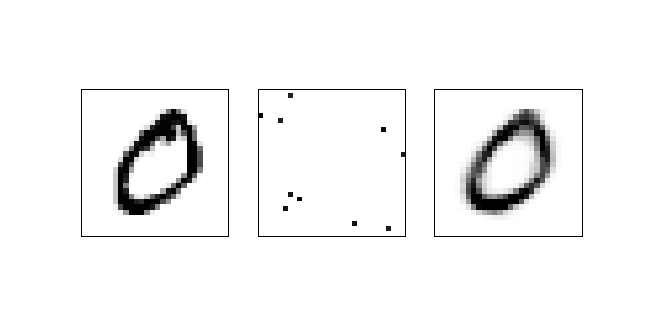

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


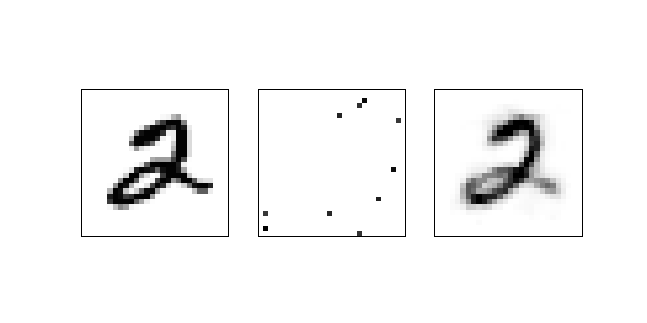

<IPython.core.display.Javascript object>


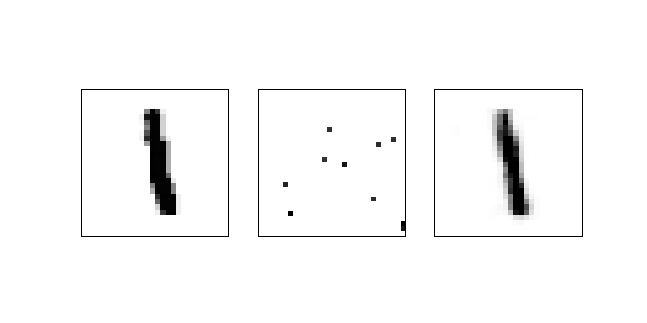

<IPython.core.display.Javascript object>


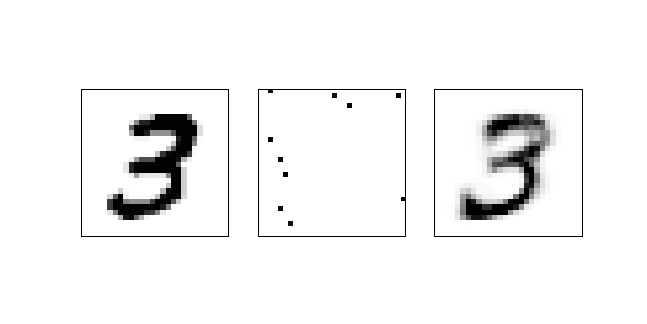

<IPython.core.display.Javascript object>


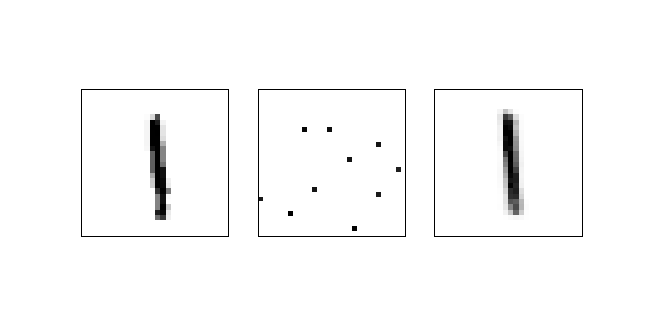

<IPython.core.display.Javascript object>

In [14]:
for i in range(10):
    reconstruct(i, w, Kx, Ky)

Well, that's deeply, deeply dope.  I'm going to run this with 1,600 neurons, and see what the flip happens??

<IPython.core.display.Javascript object>


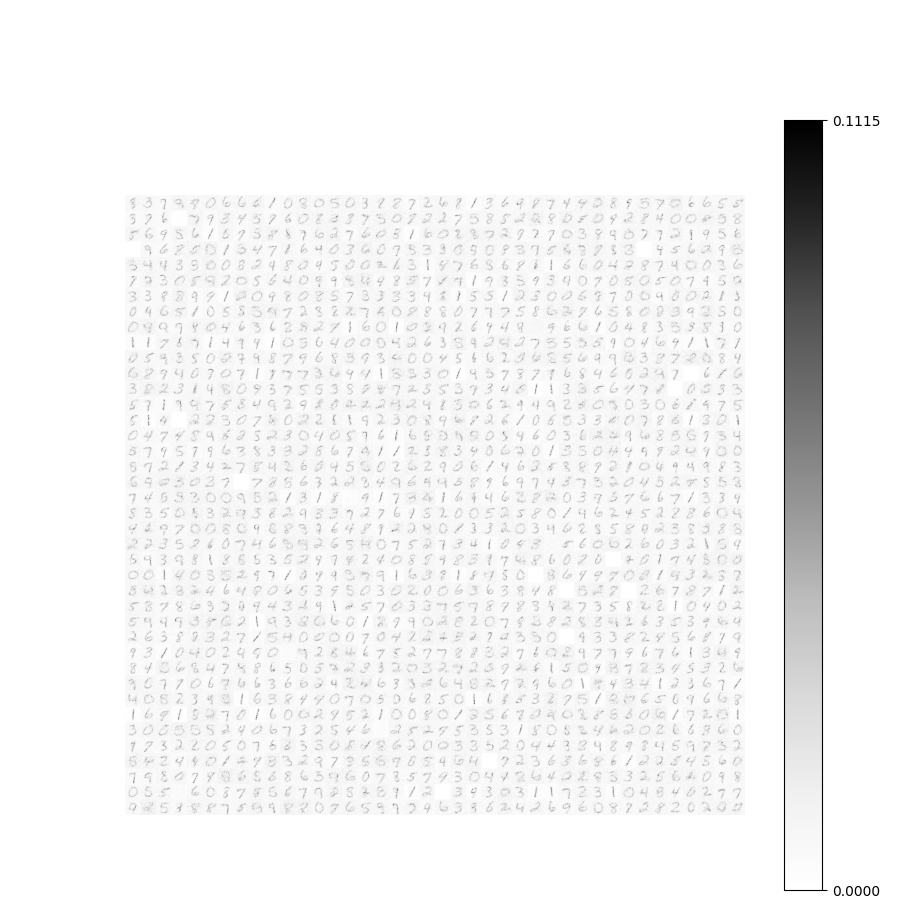

 18%|███████████                                                 | 1107/6000 [00:01<00:08, 580.45it/s]

KeyboardInterrupt: 

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 40
Ky = 40
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.01

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

Ok, that was going so fast I'm going to try something even crazier - 6,400 neurons.

In [3]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 80
Ky = 80
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.01

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:41<00:00, 145.98it/s]


In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:44<00:00, 133.72it/s]


<IPython.core.display.Javascript object>


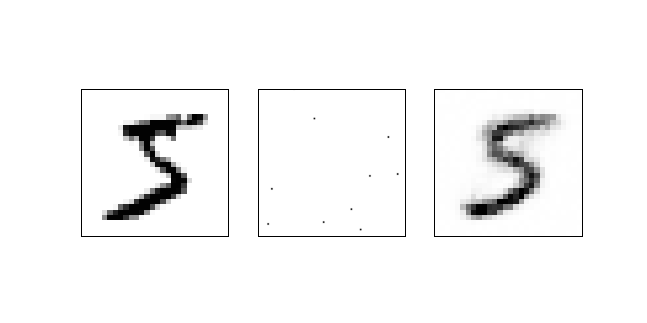

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


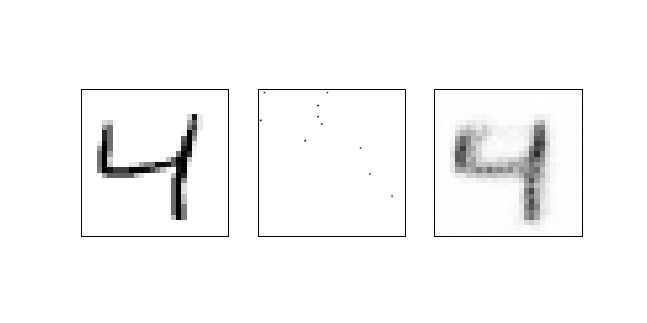

<IPython.core.display.Javascript object>


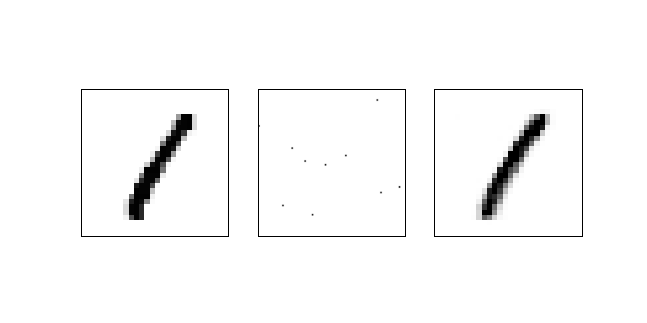

<IPython.core.display.Javascript object>


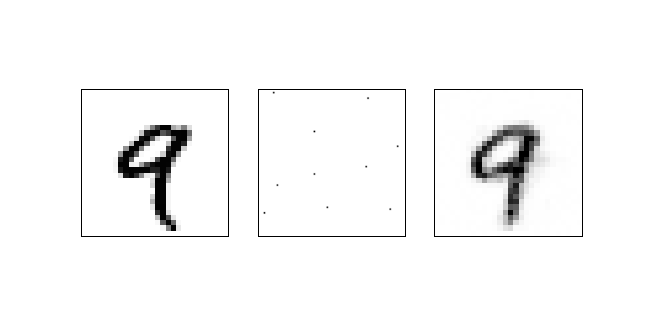

<IPython.core.display.Javascript object>


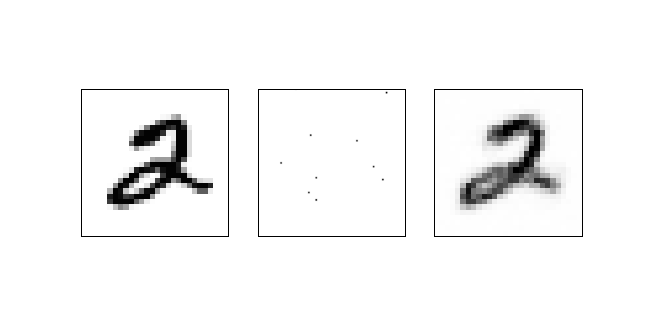

<IPython.core.display.Javascript object>


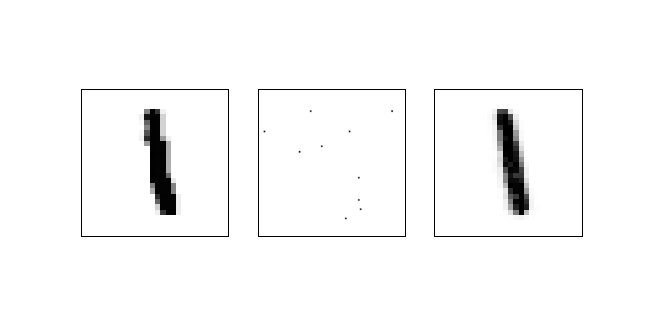

<IPython.core.display.Javascript object>


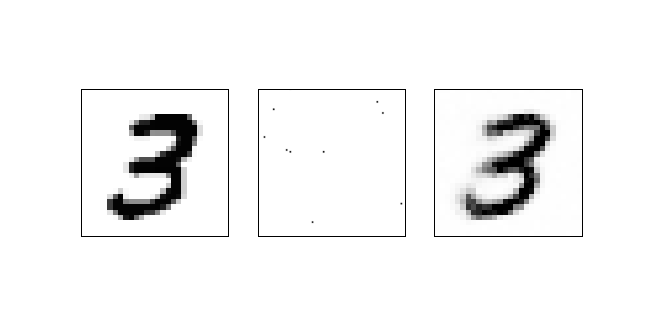

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


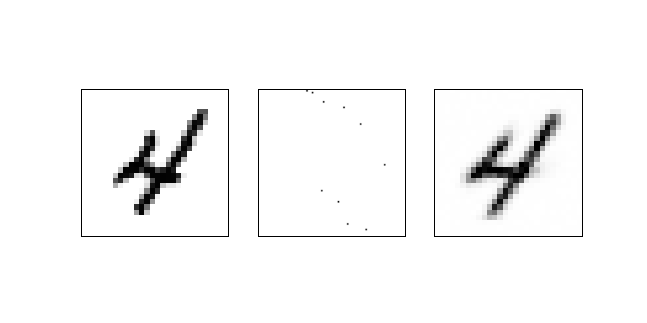

In [7]:
for i in range(10):
    reconstruct(i, w, Kx, Ky)

Dangarang.  Those are some pretty crazy good reconstructions.  What's also cool is that they seem to be simplifying the structure a bit, so the reconstructions are more smooth.  Ok, I'm going to do something totally wild.  Time for 10,000 neurons baby!

<IPython.core.display.Javascript object>


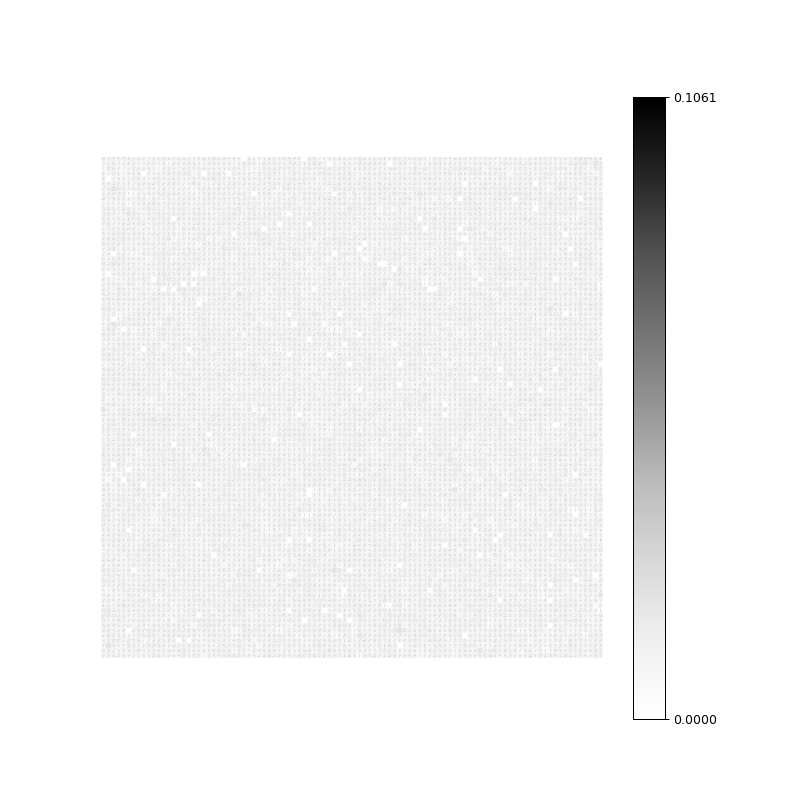

100%|█████████████████████████████████████████████████████████████| 6000/6000 [01:14<00:00, 80.65it/s]


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 100
Ky = 100
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.01

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


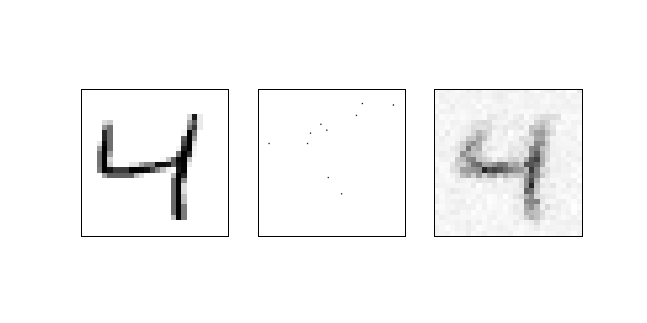

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


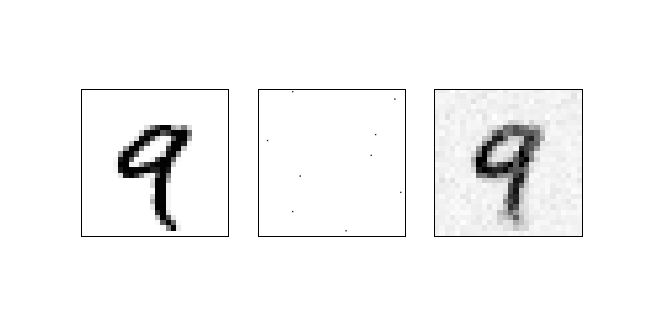

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


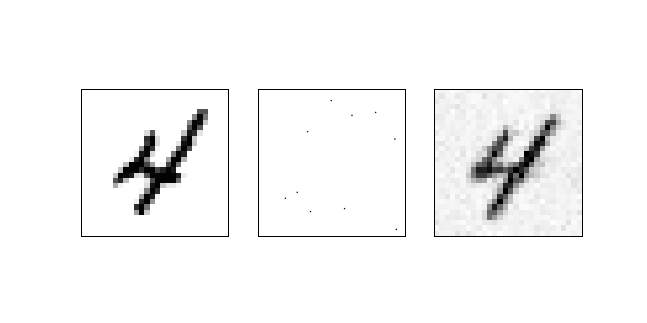

In [9]:
for i in range(10):
    reconstruct(i, w, Kx, Ky)

<IPython.core.display.Javascript object>


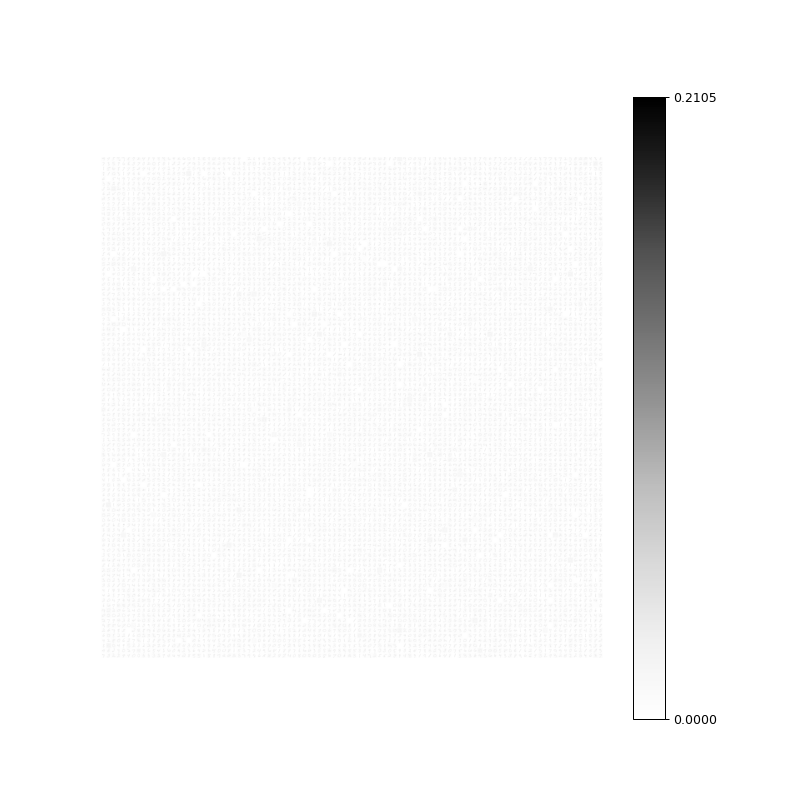

100%|█████████████████████████████████████████████████████████████| 6000/6000 [01:04<00:00, 93.20it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))


for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
#         if i % 1000 == 0: 
    w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


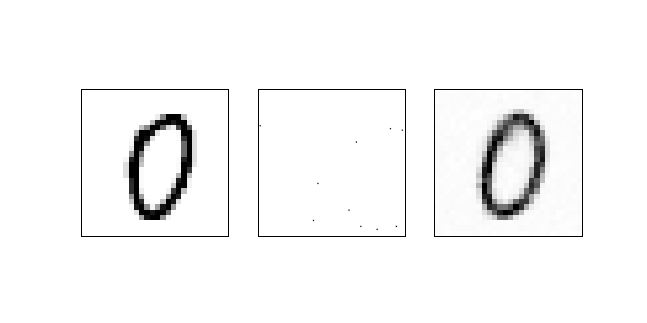

<IPython.core.display.Javascript object>


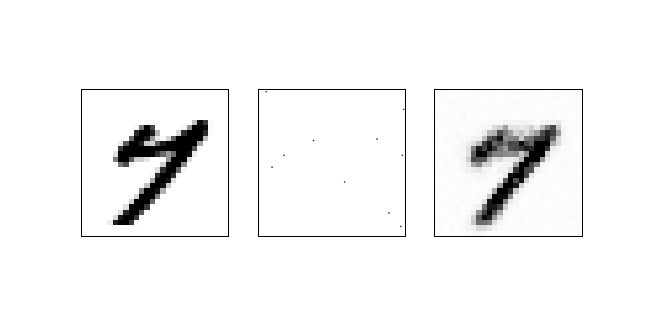

<IPython.core.display.Javascript object>


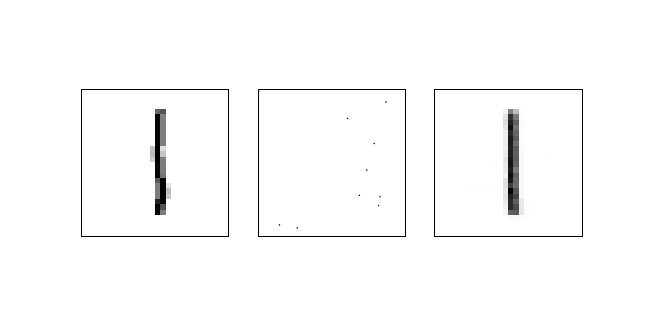

<IPython.core.display.Javascript object>


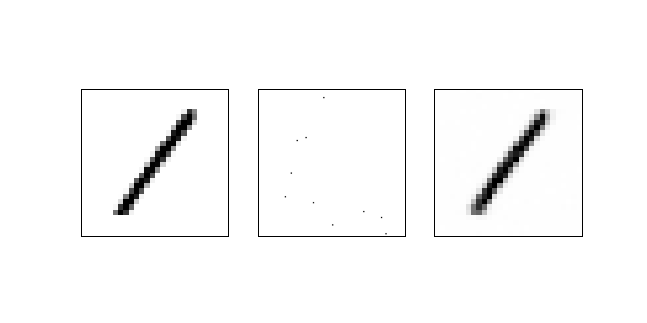

<IPython.core.display.Javascript object>


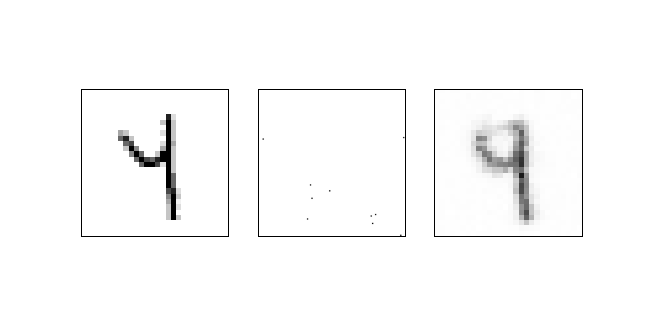

<IPython.core.display.Javascript object>


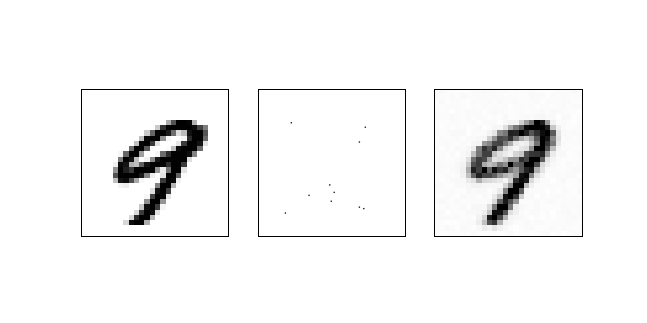

<IPython.core.display.Javascript object>


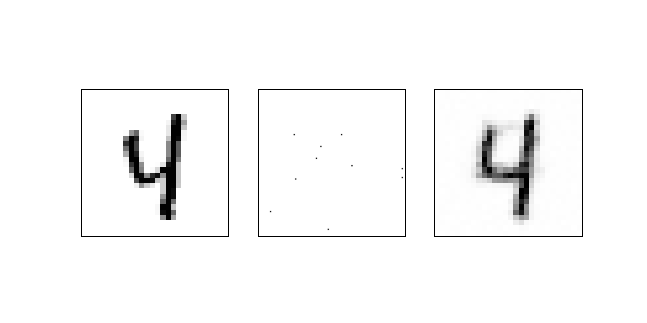

<IPython.core.display.Javascript object>


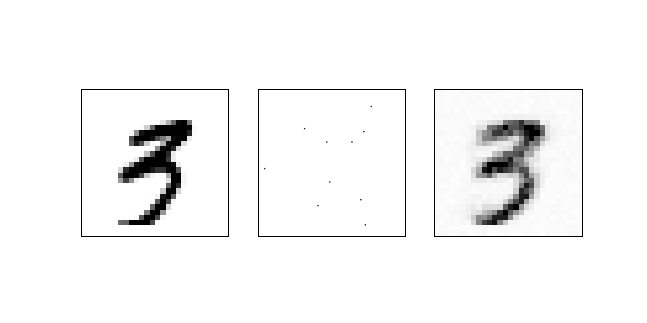

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
offset = 1000

for i in range(10):
    reconstruct(i + offset, w, Kx, Ky)

Just for the frack of it, I'm going to finish this out with 40,000 neurons.  See how long that takes.

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 30
T_s = 6000

Kx = 200
Ky = 200
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

n_w = 10 #Number of winners

N = Kx * Ky

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.02

gp_flat = cp.asarray(m_flat_tr)

for ep in range(Nep):
    inputs = gp_flat[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r

        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0: 
            w = cp.clip(w, 0, 1)

    w_n = w.get()
    draw_weights(w_n, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>

 11%|██████▊                                                       | 659/6000 [00:19<02:36, 34.09it/s]

KeyboardInterrupt: 

Just kidding.  That was going to take a really long time.  

Shoot.  This is making me wonder if I should learn CUDA.  The FPGA stuff and VHDL is kinda like the juice, but maybe CUDA is also a good thing to know about...

I'll have to decide about that.

## Conclusions

CuPy is dope, Numba is a disgusting joke.  

This is actually great because I can basically just drop CuPy in where I was using standard Numpy before.  I'll probably just make 900 neurons my standard because it only takes like 2x as long as 100 neurons.

## Next steps

Build all my neural comp networks with CuPy, baby.